In [81]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [85]:
# Load dataset
df = pd.read_csv(r'training_data_lowercase.csv', sep='\t', header=None, names=['label', 'text'])

print(df.head())
print(df.shape)


   label                                               text
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
(34152, 2)


In [87]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Check and clean dataset
df.dropna(subset=['text', 'label'], inplace=True)

# Preprocess text (lowercasing, removing punctuation, and stopwords)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation    
    stop_words = set(stopwords.words('english'))  # English text
    return ' '.join([word for word in text.split() if word not in stop_words])

df['cleaned_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
# THIS IS FOR WORD2VEC MODEL WHICH INTRODCUES EMBEDDINGS INTO THE DATA

from gensim.models import Word2Vec
from gensim.models import KeyedVectors # for Google pre-trained model that is 300 dimensional/ NOT USING IT!!!
from sklearn.model_selection import train_test_split
import numpy as np


# Step 1: Tokenize the preprocessed text into words (Word2Vec expects tokenized input)
df['tokenized_text'] = df['cleaned_text'].apply(lambda x: x.split())

# Step 2: Train the Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Convert each document (news article) into a vector by averaging the Word2Vec vectors of all words in the document
def document_vector(words, model):
    # Filter the words that are in the model's vocabulary
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    # Return the average vector of the words in the document
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(100)

# Apply the document vector function to each tokenized text 
X = np.array([document_vector(words, word2vec_model) for words in df['tokenized_text']])

# Labels
y = df['label']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# You can now use any classifier on the Word2Vec-encoded data, such as Logistic Regression, Naive Bayes, RandomForest, We are using RandomForest for this model.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 5: Train a classifier (e.g., RandomForest) using the Word2Vec features
model = RandomForestClassifier(n_estimators=250, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8322353974527887
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3529
           1       0.83      0.82      0.82      3302

    accuracy                           0.83      6831
   macro avg       0.83      0.83      0.83      6831
weighted avg       0.83      0.83      0.83      6831



In [90]:
# LEMMATIZATION with POS 

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Download stopwords from nltk
nltk.download('stopwords')


# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional for better support
nltk.download('punkt')     # Tokenizer
nltk.download('averaged_perceptron_tagger')  # POS tagging to help lemmatization

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0]  # Get the first character of the POS tag
    tag_dict = {"J": wordnet.ADJ,   # Adjective
                "N": wordnet.NOUN,  # Noun
                "V": wordnet.VERB,  # Verb
                "R": wordnet.ADV}   # Adverb
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if no match
    
# Function to lemmatize text with POS tagging
def lemmatize_text(text):
    # Lemmatize each word in the text using the POS tags
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return lemmatized_text

# Lemmatizing the input DS
df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

print(df['cleaned_text'])
df['cleaned_text'].shape


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0        donald trump sends embarrassing new year eve m...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes internet joke thr...
3        trump obsessed even obamas name coded website ...
4        pope francis called donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151    demoralized divided inside catalonia police force
Name: cleaned_text, Length: 34152, dtype: object


(34152,)

# Using TF-IDF vectorize the lemmatized dataset and train the Randomforest model

Random Forest Accuracy: 0.9041930194424924
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4420
           1       0.90      0.90      0.90      4118

    accuracy                           0.90      8538
   macro avg       0.90      0.90      0.90      8538
weighted avg       0.90      0.90      0.90      8538



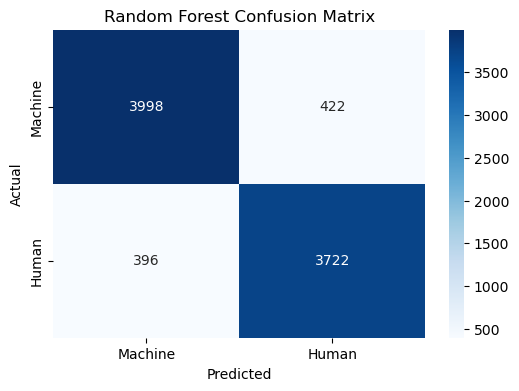

In [91]:

# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

""" # Save the Random Forest model and the TF-IDF vectorizer for future use
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f) """

# Confusion Matrix to visualize performance
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Machine', 'Human'], yticklabels=['Machine', 'Human'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()
